In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
import matplotlib.pyplot as plt

In [17]:
# Load the data
df = pd.read_csv('MaunaLoaDailyTemps.csv', index_col='DATE', parse_dates=True).dropna()

# Select the features
features = ['MinTemp', 'AvgTemp', 'Sunrise']
data = df[features].values

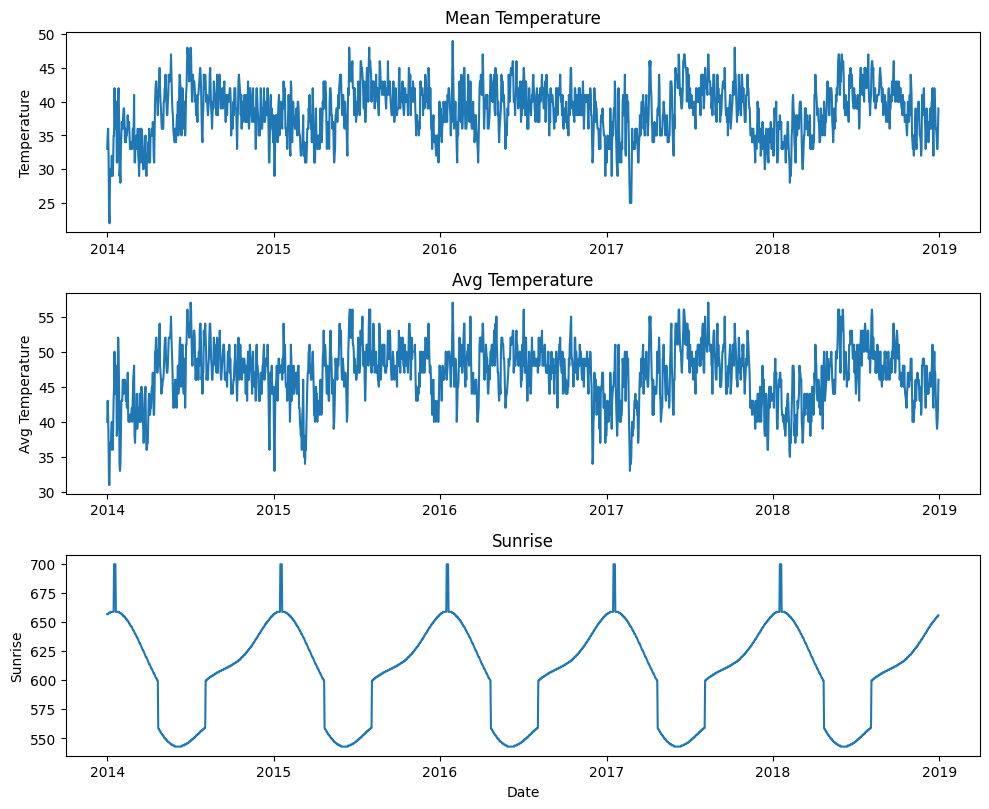

In [18]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# Plotting meanpressurem_1
axes[0].plot(df.index, df['MinTemp'])
axes[0].set_title('Mean Temperature')
axes[0].set_ylabel('Temperature')

# Plotting meantempm
axes[1].plot(df.index, df['AvgTemp'])
axes[1].set_title('Avg Temperature')
axes[1].set_ylabel('Avg Temperature')

# Plotting precipm_1
axes[2].plot(df.index, df['Sunrise'])
axes[2].set_title('Sunrise')
axes[2].set_ylabel('Sunrise')

# Adjust layout
plt.tight_layout()
plt.xlabel('Date')
plt.show()

In [19]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Define sequence length
sequence_length = 30

In [20]:
# Prepare data for training
X, y = [], []
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i+sequence_length, :])
    y.append(data_scaled[i+sequence_length, :])  # Predicting all three features

X, y = np.array(X), np.array(y)

In [21]:
# Split the dataset into training and testing sets
split = int(0.8 * len(data_scaled))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [22]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(X.shape[1], X.shape[2]), activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(3)) 
model.compile(loss='mean_squared_error', optimizer='adam')

In [23]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50


41/41 [==============================] - 1s 6ms/step - loss: 0.2968 - val_loss: 0.1544
Epoch 2/50
41/41 [==============================] - 0s 3ms/step - loss: 0.0891 - val_loss: 0.0166
Epoch 3/50
41/41 [==============================] - 0s 3ms/step - loss: 0.0125 - val_loss: 0.0114
Epoch 4/50
41/41 [==============================] - 0s 3ms/step - loss: 0.0086 - val_loss: 0.0076
Epoch 5/50
41/41 [==============================] - 0s 3ms/step - loss: 0.0081 - val_loss: 0.0074
Epoch 6/50
41/41 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.0069
Epoch 7/50
41/41 [==============================] - 0s 3ms/step - loss: 0.0077 - val_loss: 0.0066
Epoch 8/50
41/41 [==============================] - 0s 3ms/step - loss: 0.0075 - val_loss: 0.0067
Epoch 9/50
41/41 [==============================] - 0s 3ms/step - loss: 0.0073 - val_loss: 0.0062
Epoch 10/50
41/41 [==============================] - 0s 3ms/step - loss: 0.0070 - val_loss: 0.0062
Epoch 11/50
41/41 [===========

In [24]:
# Make predictions on the test set
test_predictions_scaled = model.predict(X_test)

# Inverse transform the entire test set for plotting
X_test_inverse = scaler.inverse_transform(X_test[:, -1, :])
y_test_inverse = scaler.inverse_transform(y_test)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

11/11 [==============================] - 0s 1ms/step


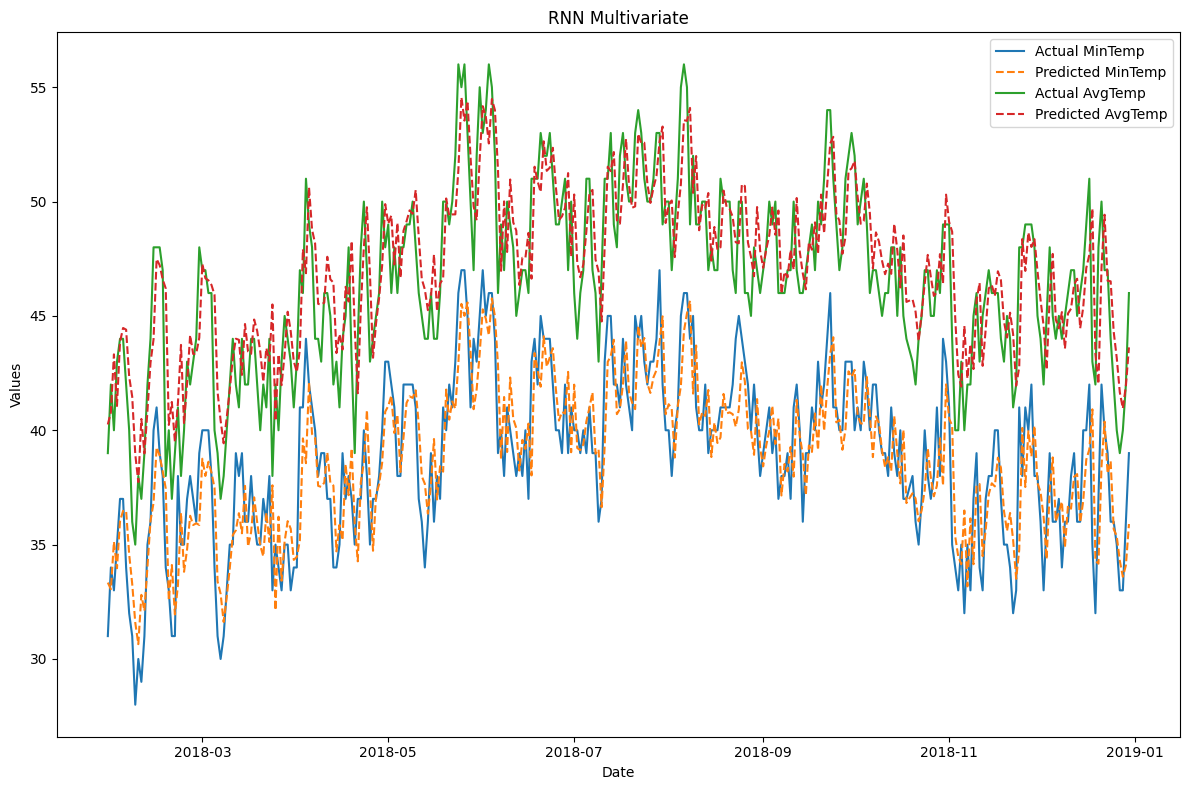

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot the results
for i in range(2):
    plt.plot(df.index[split+sequence_length:], y_test_inverse[:, i], label='Actual ' + features[i])
    plt.plot(df.index[split+sequence_length:], test_predictions[:, i], label='Predicted ' + features[i], linestyle='dashed')

plt.ylabel('Values')
plt.xlabel('Date')
plt.legend()
plt.title('RNN Multivariate')
plt.tight_layout()
plt.show()


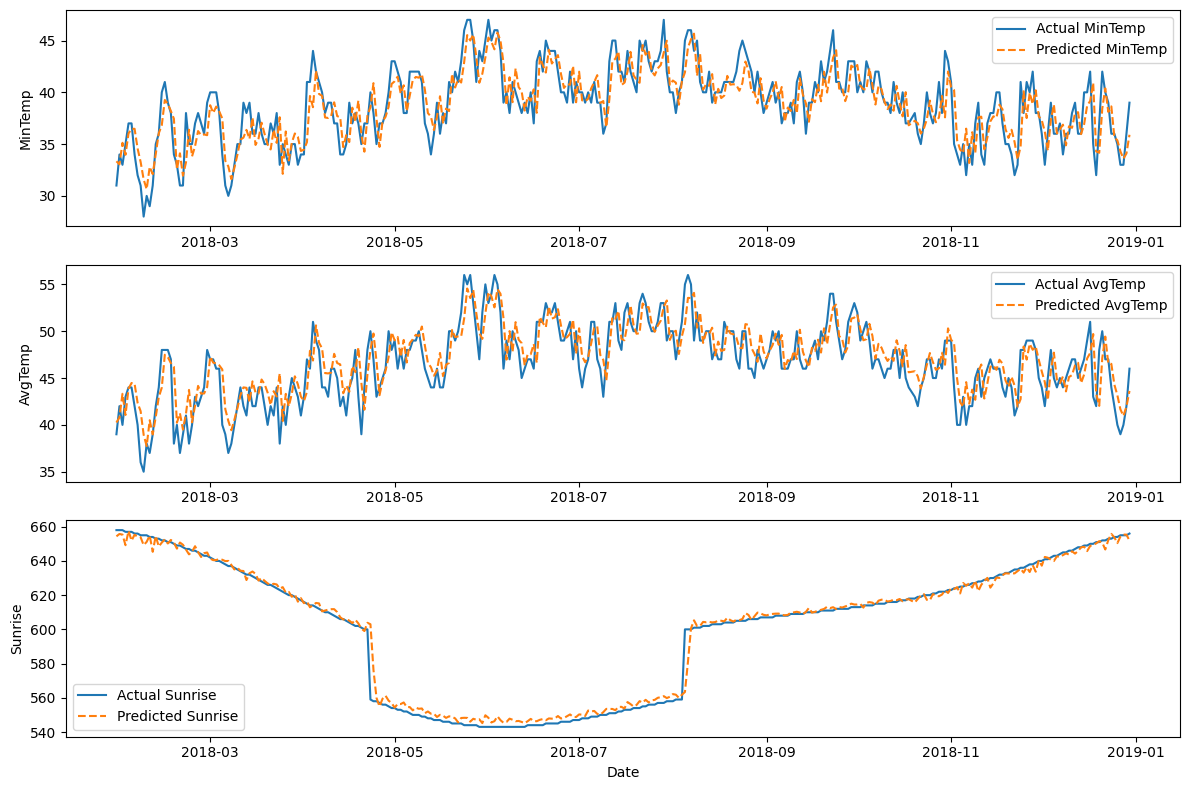

In [26]:
# Plot actual vs predicted for each feature as subplots
plt.figure(figsize=(12, 8))

# Plot the results
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(df.index[split+sequence_length:], y_test_inverse[:, i], label='Actual ' + features[i])
    plt.plot(df.index[split+sequence_length:], test_predictions[:, i], label='Predicted ' + features[i], linestyle='dashed')
    plt.ylabel(features[i])
    plt.legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE for each feature
rmse_per_feature = [np.sqrt(mean_squared_error(y_test_inverse[:, i], test_predictions[:, i])) for i in range(len(features))]

# Print RMSE for each feature
for i, feature in enumerate(features):
    print(f"RMSE for {feature}: {rmse_per_feature[i]}")


RMSE for MinTemp: 2.082785442886963
RMSE for AvgTemp: 2.3153105822027276
RMSE for Sunrise: 4.2472624282608


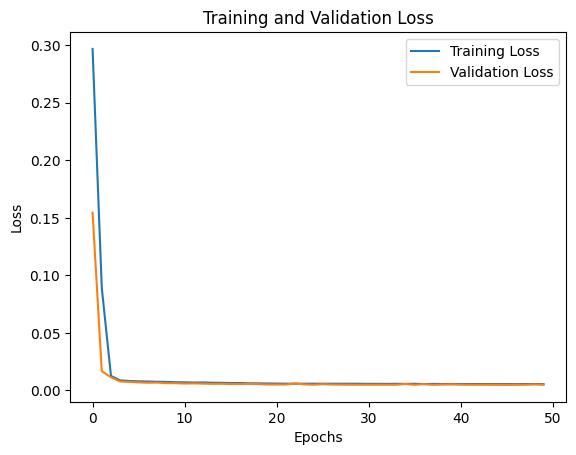

In [28]:
# Plot epochs vs loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import r2_score

# Calculate R-squared for each feature
r_squared = [r2_score(y_test_inverse[:, i], test_predictions[:, i]) for i in range(len(features))]

# Print R-squared for each feature
for i, feature in enumerate(features):
    print(f"R-squared for {feature}: {r_squared[i]}")


R-squared for MinTemp: 0.6795613727657603
R-squared for AvgTemp: 0.6718046718123036
R-squared for Sunrise: 0.9878709129481087
